In [45]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import random
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from math import sqrt
import pickle
pd.set_option('display.max_columns', 100)  # or 1000
pd.set_option('display.max_rows', 100)  # or 1000
import time
from numpy import concatenate
Scaler = MinMaxScaler()

In [47]:
## Load training dataset
# Make sure you are in the main folder('..\Algal-bloom-prediction-machine-learning')
cd = os.getcwd()
print(cd)
if cd.split('\\')[-1]!='Algal-bloom-prediction-machine-learning':
    os.chdir('..')
    cd=os.getcwd()
    
os.chdir('Trainning data')
print('Load training data (containing nutrient observations)')
lakename = input('Lake name in short: ')
winter = input('Winter data or not? (Y/N)')
if winter =='Y':
    all_df = pd.read_csv(lakename+'_Observation_df.csv',sep = '\t',parse_dates = ['Date'])
else:
    all_df = pd.read_csv(lakename+'_Observation_df_nowinter.csv',sep = '\t',parse_dates = ['Date'])

C:\Users\shuli278\Documents\D\PDF_Uppsala\7-Python code of ML algorithm\GitHub\Algal-bloom-prediction-machine-learning\Algal-bloom-prediction-machine-learning\Scenario2
Load training data (containing nutrient observations)
Lake name in short: LV
Winter data or not? (Y/N)N


In [49]:
## Specify the training year
year = all_df['Date'].apply(lambda d:d.year).unique()
print('Dataset contains years:{}'.format(year))#[2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016] 
num_trainingyr = int(input('Number of years for training:'))
training_yr = []
for i in range(num_trainingyr):
    yr = int(input('Training year:'))
    training_yr.append(yr)

Dataset contains years:[2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015]
Number of years for training:7
Training year:2005
Training year:2006
Training year:2007
Training year:2008
Training year:2009
Training year:2010
Training year:2011


# GBR model

In [8]:
# Load testing dataset(Daily data)
def read_daily_test_df(test_time,features,file): # test_time = pd.Timestamp(yyyy,mm,dd)
    Lake_HydMet = pd.read_csv(file,header = 0,sep = '\t',parse_dates = ['Date'])
    Lake_HydMet = Lake_HydMet[features]
    Lake_HydMet = Lake_HydMet[(Lake_HydMet['Date']>=test_time[0])&(Lake_HydMet['Date']<=test_time[1])].dropna()
    return Lake_HydMet

In [9]:
def training_cv(df,features,nutrient,year):
    df['YY'] = df['Date'].apply(lambda d:d.year)
    df = df[df['YY'].isin(year)].dropna()
    X_train = df[features]
    y_train = df[nutrient].values

    GBR = GradientBoostingRegressor(random_state=101)
    n_estimators = [int(x) for x in np.arange(40,140,20)]
    max_depth=[int(x) for x in np.arange(5,10,1)]
    learning_rate = [x for x in [0.01,0.1,1]]
    subsample = [x for x in [0.7,0.8,0.9,1]]
    param_grid = {'n_estimators': n_estimators,
                  'max_depth': max_depth,
                  'learning_rate':learning_rate,
                  'subsample':subsample}
    GBR_rs = RandomizedSearchCV(estimator = GBR,param_distributions = param_grid,n_iter = 30,cv = 5,verbose = 0)
    GBR_rs.fit(X_train,y_train)
    #print(GBR_rs.best_params_)
    GBR.set_params(**GBR_rs.best_params_,random_state=101).fit(X_train,y_train)
    rmse = np.sqrt(-cross_val_score(GBR, X_train, y_train, cv=5,scoring = 'neg_mean_squared_error'))
    r2 = cross_val_score(GBR, X_train, y_train, cv=5,scoring = 'r2')
    print('Training dataset evaluation:')
    print("RMSE %.2f (+/- %.2f)" % (rmse.mean(), rmse.std()))
    print("R2 %.2f (+/- %0.2f)" % (r2.mean(), r2.std()))
    pickle.dump(GBR, open("GBR."+nutrient.split('(')[0]+".dat", "wb"))

In [10]:
def predict(Lake_Nut,df,features,nutrient,test_time,ylim):
    #load the target GBR model
    GBR = pickle.load(open("GBR."+nutrient.split('(')[0]+".dat", "rb"))
    #predict yhat using test_X
    Lake_Nut[nutrient] =GBR.predict(Lake_Nut[features])
    nutrient_compare = Lake_Nut[['Date',nutrient]].merge(df[['Date',nutrient]],
                                                          how = 'inner',on = 'Date').dropna()
    nutrient_compare.columns = ['Date','Prediction','True']
    Date = pd.DataFrame(pd.date_range(start = test_time[0],
                                  end = test_time[1]),
                    columns = ['Date'])
    Lake_Nut_gap = Date.merge(Lake_Nut,how = 'left',on = 'Date')
    #nutrient_compare['Prediction_7d'] = Erken_Nut[nutrient]

    RMSE = np.sqrt(mean_squared_error(nutrient_compare['True'],nutrient_compare['Prediction']))
    #plot time-series comparison
    f2,ax2 = plt.subplots(1,2,figsize = (18,6),gridspec_kw={'width_ratios': [2, 1]})
    Lake_Nut_gap.plot(x = 'Date',y =nutrient,c = 'b',ax = ax2[0],label = 'Predicted '+nutrient)
    Lake_Nut[nutrient] = Lake_Nut[nutrient].rolling(7,min_periods = 1).mean() # take the 7-day moving mean
    Lake_Nut_gap[nutrient] = Lake_Nut_gap[nutrient].rolling(7,min_periods = 1).mean()
    Lake_Nut_gap.plot(x = 'Date',y =nutrient,c = 'k',ax = ax2[0],label = 'Predicted 7d-averaged '+nutrient)
    df[['Date',nutrient]].plot(x = 'Date',y =nutrient,style = 'ro',ms = 7,alpha = 0.7,ax = ax2[0],label = 'Observation')
    ax2[0].text(0.2, 0.8, 'RMSE:{}'.format(round(RMSE,2)), 
            horizontalalignment='center',verticalalignment='center', 
            transform=ax2[0].transAxes,fontsize='x-large')
    ax2[0].set_xlim((test_time[0],test_time[1]))
    ax2[0].set_ylim(ylim)
    
    R2 = r2_score(nutrient_compare['True'],nutrient_compare['Prediction'])
    #plot scatter plot
    ax2[1].scatter(nutrient_compare['True'],nutrient_compare['Prediction'],s = 20,c = 'blue')
    ax2[1].plot(nutrient_compare['True'],nutrient_compare['True'],lw  =1.5,color = 'black')    
    ax2[1].set_xlabel('True value')
    ax2[1].set_ylabel('Prediction')
    ax2[1].text(0.5, 0.8, 'R2:{}'.format(round(R2,2)), 
            horizontalalignment='center',verticalalignment='center', 
            transform=ax2[1].transAxes,fontsize='x-large')
    
    return Lake_Nut,f2

In [50]:
print(all_df.info())
n_feature = int(input('Number of features used for training: '))
features = ['Date']
for i in range(n_feature):
    f = input('Feature:')
    features.append(f)
print(features)
test_time = [pd.Timestamp(int(input('test starts in year:')),1,1),pd.Timestamp(int(input('test ends in year:')),1,1)]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 246 entries, 0 to 245
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Date              246 non-null    datetime64[ns]
 1   chl-a             243 non-null    float64       
 2   NH4N              211 non-null    float64       
 3   NO3N              219 non-null    float64       
 4   PO4P              240 non-null    float64       
 5   SiO2              231 non-null    float64       
 6   TOC               145 non-null    float64       
 7   TOTN              233 non-null    float64       
 8   TOTP              240 non-null    float64       
 9   O2                195 non-null    float64       
 10  AirP              246 non-null    float64       
 11  AirT              246 non-null    float64       
 12  RelHum            246 non-null    float64       
 13  SWR               246 non-null    float64       
 14  CC                246 non-

In [51]:
if winter =='Y':
    file = lakename+'_Daily_Observation_df.csv'
else:
    file = lakename+'_Daily_Observation_df_nowinter.csv'
testing_daily_df = read_daily_test_df(test_time,features,file) 

Nutrient: O2
Training dataset evaluation:
RMSE 1.70 (+/- 0.30)
R2 -0.46 (+/- 0.67)


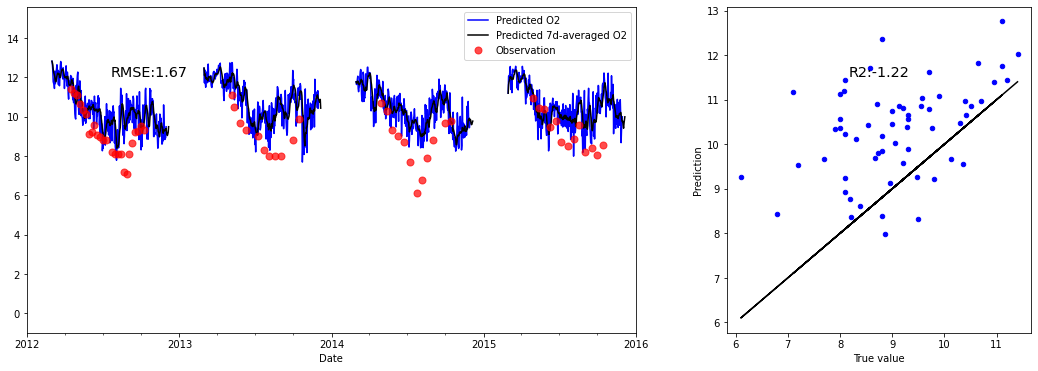

In [52]:
## Predict nutrient 1
nutrient = input('Nutrient: ')
features.pop(0) # remove 'Date' from features
model = training_cv(all_df,features,nutrient,training_yr)
ylim = (-1,all_df[nutrient].max())
Lake_Nut,f2 = predict(testing_daily_df,all_df,features,nutrient,test_time,ylim)
os.chdir('..\\Scenario2\\GBR')
f2.savefig(lakename+'_GBR_'+nutrient+'.png',dpi = 500)

Nutrient: NO3N
['AirP', 'AirT', 'RelHum', 'SWR', 'CC', 'Prec', 'U', 'delT', 'inflow(m3/s)', 'outflow(m3/s)', 'Ice_d', 'days from iceoff', 'W', 'MLD', 'thermD']
Delete features? (Y/N)N
Add features? (Y/N)Y
New feature:O2
['AirP', 'AirT', 'RelHum', 'SWR', 'CC', 'Prec', 'U', 'delT', 'inflow(m3/s)', 'outflow(m3/s)', 'Ice_d', 'days from iceoff', 'W', 'MLD', 'thermD', 'O2']
Add features? (Y/N)N
Training dataset evaluation:
RMSE 218.08 (+/- 54.28)
R2 -0.28 (+/- 0.54)


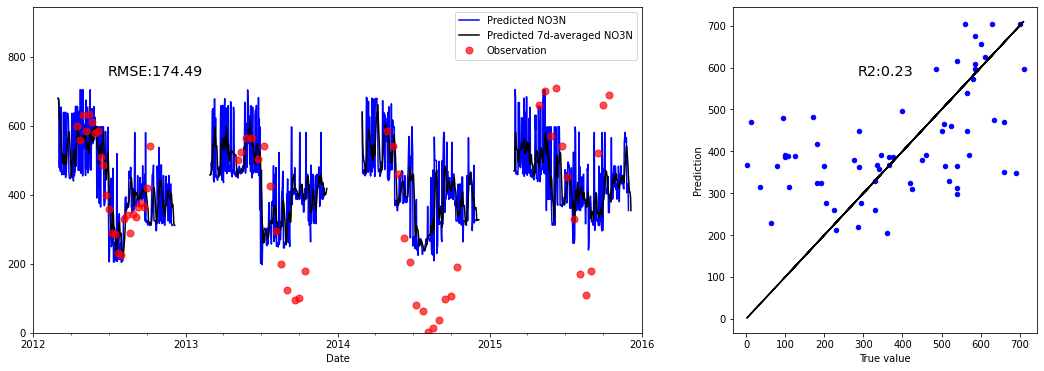

In [53]:
## Predict nutrient 2
nutrient = input('Nutrient: ')
print(features)
delet = input('Delete features? (Y/N)')
while delet=='Y':
    print(features)
    idx = int(input('Location of the feature:'))
    features.pop(idx)
    delet = input('Delete features? (Y/N)')
add = input('Add features? (Y/N)')
while add =='Y':
    f = input('New feature:')
    features.append(f)
    print(features)
    add = input('Add features? (Y/N)')    
model = training_cv(all_df,features,nutrient,training_yr)
ylim = (0,all_df[nutrient].max())
Lake_Nut,f2 = predict(testing_daily_df,all_df,features,nutrient,test_time,ylim)
f2.savefig(lakename+'_GBR_'+nutrient+'.png',dpi = 500)

Nutrient: NH4N
['AirP', 'AirT', 'RelHum', 'SWR', 'CC', 'Prec', 'U', 'delT', 'inflow(m3/s)', 'outflow(m3/s)', 'Ice_d', 'days from iceoff', 'W', 'MLD', 'thermD', 'O2']
Delete features? (Y/N)N
Add features? (Y/N)Y
New feature:NO3N
['AirP', 'AirT', 'RelHum', 'SWR', 'CC', 'Prec', 'U', 'delT', 'inflow(m3/s)', 'outflow(m3/s)', 'Ice_d', 'days from iceoff', 'W', 'MLD', 'thermD', 'O2', 'NO3N']
Add features? (Y/N)N
Training dataset evaluation:
RMSE 11.62 (+/- 4.36)
R2 -0.23 (+/- 0.20)


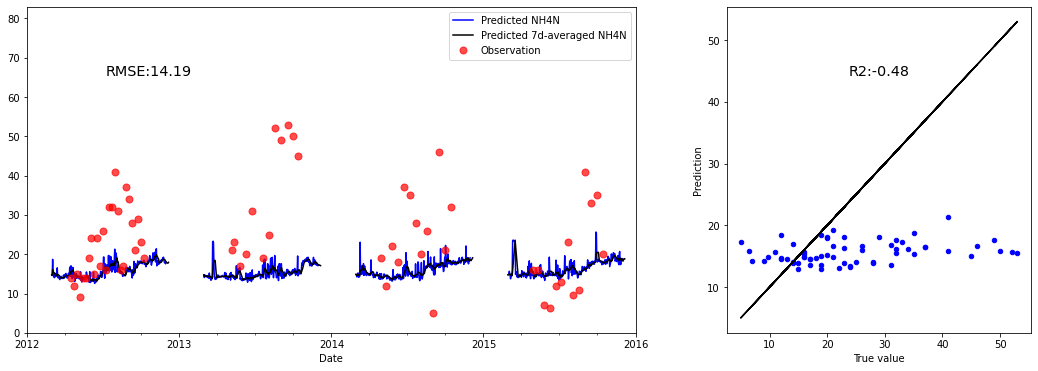

In [54]:
## Predict nutrient 3
nutrient = input('Nutrient: ')
print(features)
delet = input('Delete features? (Y/N)')
while delet=='Y':
    print(features)
    idx = int(input('Location of the feature:'))
    features.pop(idx)
    delet = input('Delete features? (Y/N)')
add = input('Add features? (Y/N)')
while add =='Y':
    f = input('New feature:')
    features.append(f)
    print(features)
    add = input('Add features? (Y/N)')    
model = training_cv(all_df,features,nutrient,training_yr)
ylim = (0,all_df[nutrient].max())
Lake_Nut,f2 = predict(testing_daily_df,all_df,features,nutrient,test_time,ylim)
f2.savefig(lakename+'_GBR_'+nutrient+'.png',dpi = 500)

Nutrient: PO4P
['AirP', 'AirT', 'RelHum', 'SWR', 'CC', 'Prec', 'U', 'delT', 'inflow(m3/s)', 'outflow(m3/s)', 'Ice_d', 'days from iceoff', 'W', 'MLD', 'thermD', 'O2', 'NO3N']
Delete features? (Y/N)N
Add features? (Y/N)N
Training dataset evaluation:
RMSE 2.43 (+/- 0.32)
R2 -0.15 (+/- 0.31)


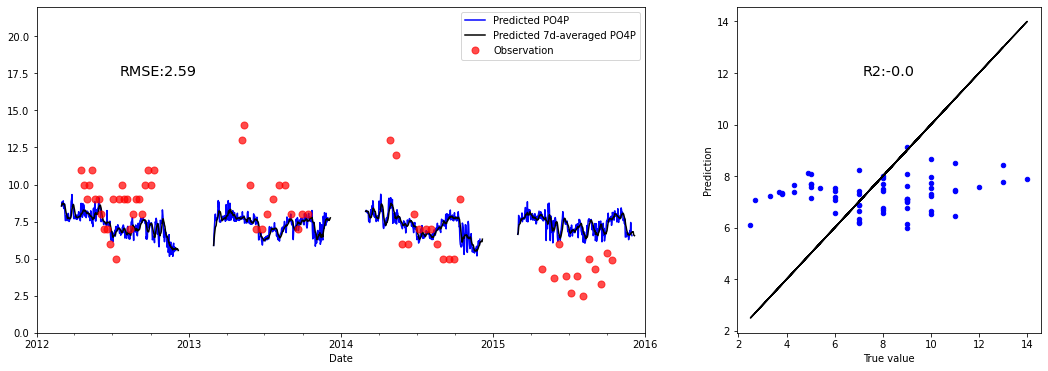

In [55]:
## Predict nutrient 4
nutrient = input('Nutrient: ')
print(features)
delet = input('Delete features? (Y/N)')
while delet=='Y':
    print(features)
    idx = int(input('Location of the feature:'))
    features.pop(idx)
    delet = input('Delete features? (Y/N)')
add = input('Add features? (Y/N)')
while add =='Y':
    f = input('New feature:')
    features.append(f)
    print(features)
    add = input('Add features? (Y/N)')    
model = training_cv(all_df,features,nutrient,training_yr)
ylim = (0,all_df[nutrient].max())
Lake_Nut,f2 = predict(testing_daily_df,all_df,features,nutrient,test_time,ylim)
f2.savefig(lakename+'_GBR_'+nutrient+'.png',dpi = 500)

Nutrient: TOTP
['AirP', 'AirT', 'RelHum', 'SWR', 'CC', 'Prec', 'U', 'delT', 'inflow(m3/s)', 'outflow(m3/s)', 'Ice_d', 'days from iceoff', 'W', 'MLD', 'thermD', 'O2', 'NO3N']
Delete features? (Y/N)N
Add features? (Y/N)N
Training dataset evaluation:
RMSE 4.76 (+/- 0.98)
R2 -0.54 (+/- 0.44)


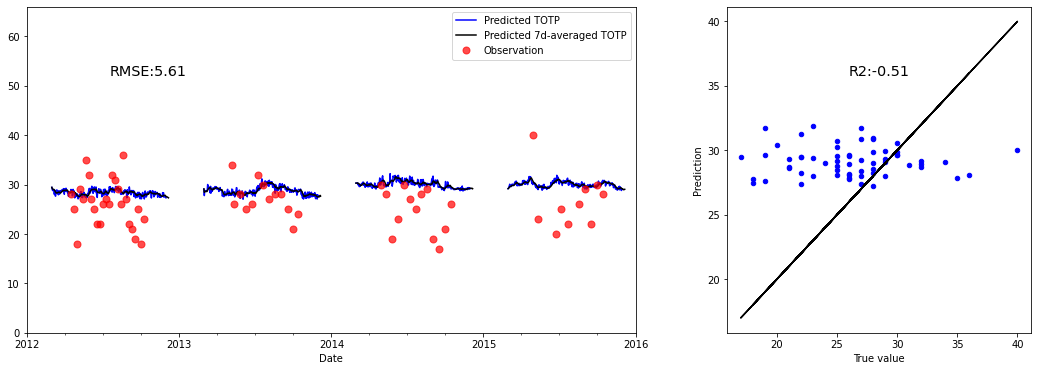

In [56]:
## Predict nutrient 5
nutrient = input('Nutrient: ')
print(features)
delet = input('Delete features? (Y/N)')
while delet=='Y':
    print(features)
    idx = int(input('Location of the feature:'))
    features.pop(idx)
    delet = input('Delete features? (Y/N)')
add = input('Add features? (Y/N)')
while add =='Y':
    f = input('New feature:')
    features.append(f)
    print(features)
    add = input('Add features? (Y/N)')    
model = training_cv(all_df,features,nutrient,training_yr)
ylim = (0,all_df[nutrient].max())
Lake_Nut,f2 = predict(testing_daily_df,all_df,features,nutrient,test_time,ylim)
f2.savefig(lakename+'_GBR_'+nutrient+'.png',dpi = 500)

Nutrient: TOTN
['AirP', 'AirT', 'RelHum', 'SWR', 'CC', 'Prec', 'U', 'delT', 'inflow(m3/s)', 'outflow(m3/s)', 'Ice_d', 'days from iceoff', 'W', 'MLD', 'thermD', 'O2', 'NO3N']
Delete features? (Y/N)N
Add features? (Y/N)N
Training dataset evaluation:
RMSE 136.69 (+/- 51.75)
R2 0.47 (+/- 0.31)


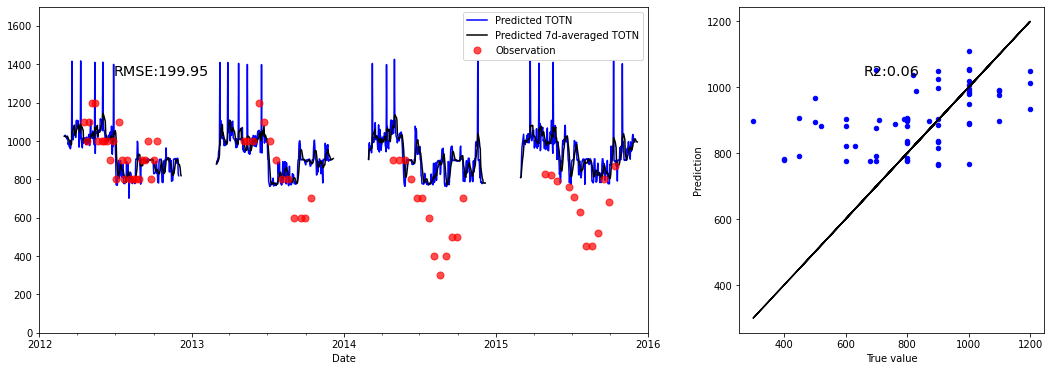

In [57]:
## Predict nutrient 6
nutrient = input('Nutrient: ')
print(features)
delet = input('Delete features? (Y/N)')
while delet=='Y':
    print(features)
    idx = int(input('Location of the feature:'))
    features.pop(idx)
    delet = input('Delete features? (Y/N)')
add = input('Add features? (Y/N)')
while add =='Y':
    f = input('New feature:')
    features.append(f)
    print(features)
    add = input('Add features? (Y/N)')    
model = training_cv(all_df,features,nutrient,training_yr)
ylim = (0,all_df[nutrient].max())
Lake_Nut,f2 = predict(testing_daily_df,all_df,features,nutrient,test_time,ylim)
f2.savefig(lakename+'_GBR_'+nutrient+'.png',dpi = 500)

Nutrient: TOC
Delete features? (Y/N)N
Add features? (Y/N)TOTN
Training dataset evaluation:
RMSE 0.67 (+/- 0.39)
R2 -0.62 (+/- 0.31)
Figure name:LV_GBR_TOC


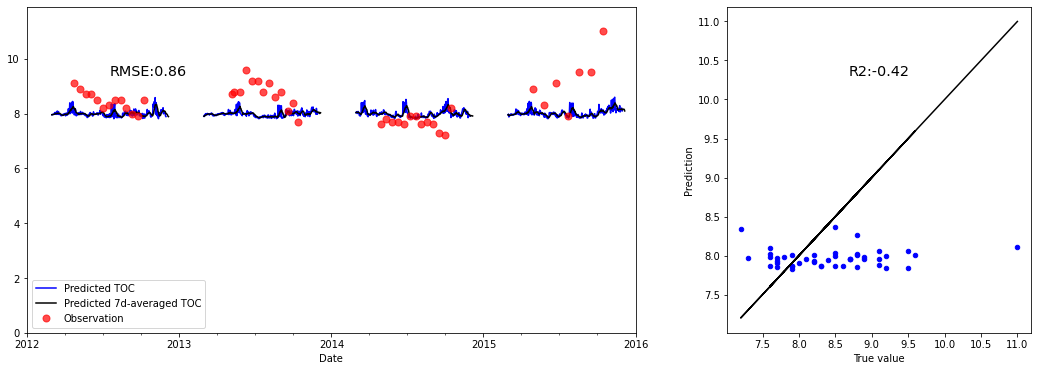

In [58]:
## Predict nutrient 7
nutrient = input('Nutrient: ')
print(features)
delet = input('Delete features? (Y/N)')
while delet=='Y':
    print(features)
    idx = int(input('Location of the feature:'))
    features.pop(idx)
    delet = input('Delete features? (Y/N)')
    
add = input('Add features? (Y/N)')
while add =='Y':
    f = input('New feature:')
    features.append(f)
    print(features)
    add = input('Add features? (Y/N)')  
    
model = training_cv(all_df,features,nutrient,training_yr)
ylim = (0,all_df[nutrient].max())
Lake_Nut,f2 = predict(testing_daily_df,all_df,features,nutrient,test_time,ylim)
f2.savefig(lakename+'_GBR_'+nutrient+'.png',dpi = 500)

Nutrient: SiO2
['AirP', 'AirT', 'RelHum', 'SWR', 'CC', 'Prec', 'U', 'delT', 'inflow(m3/s)', 'outflow(m3/s)', 'Ice_d', 'days from iceoff', 'W', 'MLD', 'thermD', 'O2', 'NO3N']
Delete features? (Y/N)N
Add features? (Y/N)N
Training dataset evaluation:
RMSE 0.70 (+/- 0.24)
R2 0.64 (+/- 0.16)


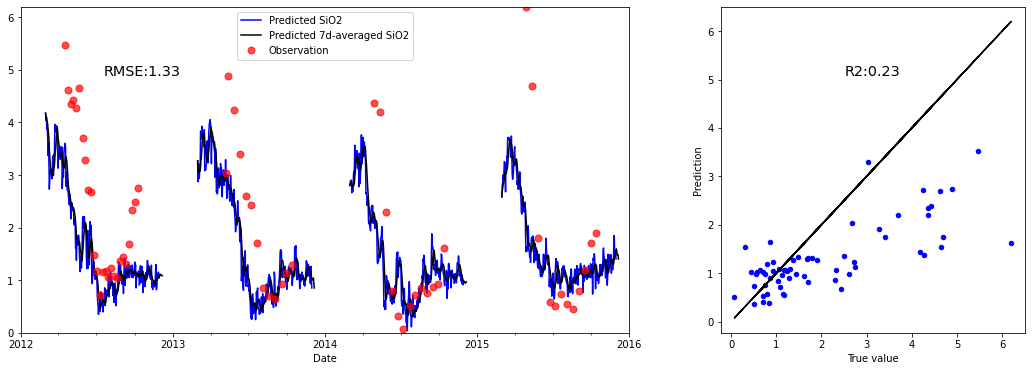

In [59]:
## Predict nutrient 8
nutrient = input('Nutrient: ')
print(features)
delet = input('Delete features? (Y/N)')
while delet=='Y':
    print(features)
    idx = int(input('Location of the feature:'))
    features.pop(idx)
    delet = input('Delete features? (Y/N)')
    
add = input('Add features? (Y/N)')
while add =='Y':
    f = input('New feature:')
    features.append(f)
    print(features)
    add = input('Add features? (Y/N)')    
model = training_cv(all_df,features,nutrient,training_yr)
ylim = (0,all_df[nutrient].max())
Lake_Nut,f2 = predict(testing_daily_df,all_df,features,nutrient,test_time,ylim)
f2.savefig(lakename+'_GBR_'+nutrient+'.png',dpi = 500)

Nutrient: chl-a
['AirP', 'AirT', 'RelHum', 'SWR', 'CC', 'Prec', 'U', 'delT', 'inflow(m3/s)', 'outflow(m3/s)', 'Ice_d', 'days from iceoff', 'W', 'MLD', 'thermD', 'O2', 'NO3N', 'TOC', 'TOTN', 'SiO2']
Delete features? (Y/N)Y
['AirP', 'AirT', 'RelHum', 'SWR', 'CC', 'Prec', 'U', 'delT', 'inflow(m3/s)', 'outflow(m3/s)', 'Ice_d', 'days from iceoff', 'W', 'MLD', 'thermD', 'O2', 'NO3N', 'TOC', 'TOTN', 'SiO2']
Location of the feature:-2
Delete features? (Y/N)N
Add features? (Y/N)N
Training dataset evaluation:
RMSE 5.29 (+/- 1.00)
R2 0.06 (+/- 0.32)


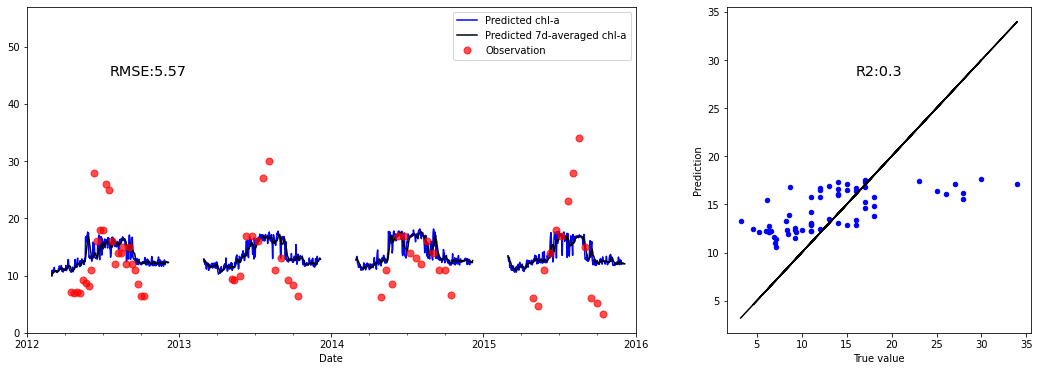

In [65]:
## Predict Chl
nutrient = input('Nutrient: ')
print(features)
delet = input('Delete features? (Y/N)')
while delet=='Y':
    print(features)
    idx = int(input('Location of the feature:'))
    features.pop(idx)
    delet = input('Delete features? (Y/N)')
add = input('Add features? (Y/N)')
while add =='Y':
    f = input('New feature:')
    features.append(f)
    print(features)
    add = input('Add features? (Y/N)') 
    
model = training_cv(all_df,features,nutrient,training_yr)
ylim = (0,all_df[nutrient].max())
Lake_Nut,f2 = predict(testing_daily_df,all_df,features,nutrient,test_time,ylim)
f2.savefig(lakename+'_GBR_'+nutrient+'.png',dpi = 500)

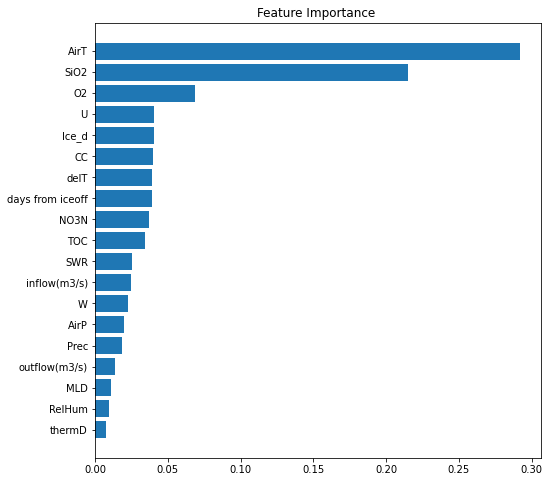

In [66]:
GBR = pickle.load(open('GBR.'+nutrient+'.dat','rb'))
feature_importance = GBR.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + 0.5
fig = plt.figure(figsize=(8, 8))
plt.barh(pos, feature_importance[sorted_idx], align="center")
plt.yticks(pos, np.array(features)[sorted_idx])
plt.title("Feature Importance ")

#shap_values = shap.TreeExplainer(GBR).shap_values(Lake_Nut[features])
#shap.summary_plot(shap_values,Lake_Nut[features],plot_type = 'bar',show=False)
plt.savefig(lakename+'_Feature ranking.png')

In [62]:
Lake_Nut.to_csv(lakename+'_GBR predicted nutrient and Chl.csv',index = False)